# Training a classifier

This code trains a Convolutional Neural Network to recognize the next classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') with dataset CIFAR10 from torchvision.

## Import libraries

**torch**: provides nn.Module to create a neural network, functional to apply activation functions; Dataset, DataLoader and random_split to load and divide data in train, validation, and test, and Adam (optimizer).

**torchvision**: provides data transforms and images with labels.

In [93]:
import torch
import torchvision
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam

### Choosing device
The **CPU** is composed of very few cores, but those cores are individually very powerful and smart, whereas the **GPU** is composed of a very large number of weaker cores. [[1](https://medium.com/@sahil_g/cpu-vs-gpu-pytorch-tensor-operations-50e215ff764a)]

In [94]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
else:
  devide = 'cpu'

print(device)

cuda


### Load data

We should transforms data to Tensor and normalize this data. We use CIFAR10 dataset, there are 50000 train images in this dataset with a (3x32x32) format and 10000 test images. We divide test images in test and validation datasets. All images have a label.

In [95]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
data_train = torchvision.datasets.CIFAR10(root="./data/", train = True,
                                          transform=transform,
                                          download = True)
data_val_test = torchvision.datasets.CIFAR10(root="./data/", train = False,
                                             transform=transform, download = True,)
print(len(data_train), len(data_val_test))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


We split validation and test data in 5000 and 5000, respectively.

In [96]:
data_val, data_test = random_split(data_val_test, [5000, 5000])

We use DataLoader to load dataset in our model and our batch_size will be 4.

In [97]:
batch_size = 4
dataloader_train = DataLoader(data_train, batch_size = batch_size, num_workers=2, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size = batch_size, num_workers=2, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size = batch_size, num_workers=2, shuffle=False)

In [98]:
# Our classes are: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Visualization of 4 images with 3 channels and their labels

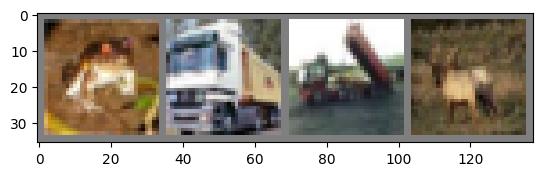

frog  truck truck deer 


In [99]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(dataloader_train)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

print(" ".join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Model Creation

We use the next architecture:

<img src="./Architecture.png">

This architecture is sequential, a layer before another layer.

[1] Conv2d -> in channels: 3, out channels = 6, kernel = 5

[1.1] MaxPool2d -> kernel: 2x2

[2] Conv2d -> in channels: 6, out channels = 16, kernel = 5

[2.1] MaxPool2d -> kernel: 2x2

[3] FC Layer -> input: 400, output = 120

[4] FC Layer -> input: 120, output = 84

[5] FC Layer -> input: 84, output = 10


In [115]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

How we have many classes to classify, we use CrossEntropyLoss, we could use other option, for this example, this CrossEntroppy is well. And Adam will be our optimizer and learning rate of 0.001.

In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr = 0.001)

### Training

We will train with 10 epochs.

In [117]:
for epoch in range(10):
  loss_train = 0
  net.train()
  for i, batch in enumerate(dataloader_train, 0):
    optimizer.zero_grad()
    input, label = batch
    output = net(input.cuda())
    loss = criterion(output, label.cuda())
    loss.backward()
    loss_train += loss.item()
    optimizer.step()

    if i % 2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss_train: {loss_train / 2000:.3f}')
      loss_train = 0

  net.eval()
  loss_val = 0
  for i, batch in enumerate(dataloader_val, 0):
    input, label = batch
    output = net(input.cuda())
    loss = criterion(output, label.cuda())
    loss_val += loss.item()

    if i % 1000 == 0:
      print(f'[{epoch + 1}, {i + 1:5d}] loss_val: {loss_val / 2000:.3f}')
      loss_val = 0

print('Finished Training')

[1,  2000] loss_train: 1.871
[1,  4000] loss_train: 1.626
[1,  6000] loss_train: 1.525
[1,  8000] loss_train: 1.467
[1, 10000] loss_train: 1.454
[1, 12000] loss_train: 1.411
[1,     1] loss_val: 0.001
[1,    11] loss_val: 0.006
[1,    21] loss_val: 0.007
[1,    31] loss_val: 0.007
[1,    41] loss_val: 0.007
[1,    51] loss_val: 0.007
[1,    61] loss_val: 0.006
[1,    71] loss_val: 0.008
[1,    81] loss_val: 0.006
[1,    91] loss_val: 0.007
[1,   101] loss_val: 0.006
[1,   111] loss_val: 0.008
[1,   121] loss_val: 0.006
[1,   131] loss_val: 0.008
[1,   141] loss_val: 0.007
[1,   151] loss_val: 0.008
[1,   161] loss_val: 0.007
[1,   171] loss_val: 0.007
[1,   181] loss_val: 0.006
[1,   191] loss_val: 0.007
[1,   201] loss_val: 0.009
[1,   211] loss_val: 0.006
[1,   221] loss_val: 0.008
[1,   231] loss_val: 0.006
[1,   241] loss_val: 0.007
[1,   251] loss_val: 0.008
[1,   261] loss_val: 0.007
[1,   271] loss_val: 0.007
[1,   281] loss_val: 0.006
[1,   291] loss_val: 0.006
[1,   301] loss_

### Save the model

In [118]:
PATH = './cifar_net'
torch.save(net.state_dict(), PATH)

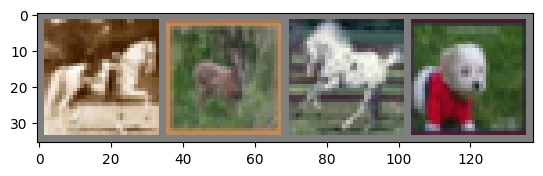

GroundTruth:  horse deer  horse dog  


In [119]:
dataiter = iter(dataloader_test)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [120]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

### Predicting

In [121]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

Predicted:  horse deer  horse horse
